<a href="https://colab.research.google.com/github/BirenderPanwar/EVA4_Phase1/blob/master/session9/EVA4S9_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentaion using albumentations library and applying GradCAM (an Xray for network)
1. resnet18 model
2. calculate mean and std for the entire dataset and apply data normalization
3. Image augmentation using albumentations library: horizontal flip, croping, cutout, elastic transform
4. Build and train the network using L1 and L2 regularization is applied. 
5. GradCAM

In [0]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Check for current directory and necessary files availability

In [0]:
# check current directory
!pwd

/content


In [0]:
# change to working directory
cd '/content/gdrive/My Drive/TSAI/EVA_Phase1/session9/s9_submission/'

/content/gdrive/My Drive/TSAI/EVA_Phase1/session9/s9_submission


In [0]:
# verify if all necessary files are avaiabale in current directory for loading
!ls

print("\nfiles under /models: ")
!ls ./models/

print("\nfiles under /utils: ")
!ls ./utils/

print("\nfiles under /gradcam: ")
!ls ./gradcam/

data		   EVA4S9_main_v1.ipynb  images  readme.md     utils
EVA4S9_main.ipynb  gradcam		 models  saved_models

files under /models: 
cifar10_net_cnn.py  __pycache__  resnet.py

files under /utils: 
albumentations_utils.py  data_utils.py	   model_utils.py  __pycache__
common_utils.py		 model_history.py  plot_utils.py   regularization.py

files under /gradcam: 
gradcam_abs.py	gradcam.py  gradcam_utils.py  __pycache__


# Load standard and custom python packages

In [0]:
# Load standard packages

from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR, OneCycleLR

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import albumentations # to apply image augmentation using albumentations library.
print(albumentations.__version__) # check verison

# this is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.5"
if albumentations.__version__ != album_version_needed:
  !pip install -U git+https://github.com/albu/albumentations --no-cache-dir

0.4.5


In [0]:
# load custom python packages
import utils.common_utils as cutils          # common utililies fxn
import utils.model_utils as mutils           # utilities for basic conv block, depthwise seperable blocks, train, test, build fucntions
import utils.model_history as model_history  # utilitie for storing and visualizing model results
import utils.plot_utils as putils            # utilities for ploting images, model history, misclassified images etc
import models.cifar10_net_cnn as cifar10_net_cnn  # CIFAR10 network design using custom CNN network
import models.resnet as resnet                    # resnet model

import utils.albumentations_utils as album_utils # utilities fxn based on albumentations
import gradcam.gradcam_abs as gradcamAbs         # abstraction for GradCam module


In [0]:
# to autoreload all the custom files when modified
import autoreload
%load_ext autoreload
%autoreload

# Check GPU avaiability
use cuda and get device with GPU

In [0]:
# check GPU availability and use cuda to get GPU device
cuda, device = cutils.get_device()

CUDA Available? True
Device:  cuda:0


# Basis configurations for CIFAR10

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

config_params = dict(
    seed=1,
    batch_size=128,
    num_workers=4,
    epochs=40
)

# For reproducibility
torch.manual_seed(config_params["seed"])

if cuda:
    torch.cuda.manual_seed(config_params["seed"])

# Albumentations: Data Preprocessing and Loading of  CIFAR10 dataset
1. first calculate the mean and std for the entire dataset. this will be used for dataset normalization during data transform
2. define data transforms-image augmentation, toSensor, normalization etc
3. load the dataset using data loader

In [0]:
means, stds = album_utils.calculate_dataset_mean_std()
print("means: {}".format(means))
print("stds: {}".format(stds))

Files already downloaded and verified
Files already downloaded and verified

Total dataset(train+test) shape:  (60000, 32, 32, 3)
means: [0.49186864, 0.48265335, 0.44717798]
stds: [0.24697131, 0.24338901, 0.26159254]


In [0]:

# fill values for cutout portion
fill_value = [255. * mean for mean in means]

# to apply specific augmentation, set apply=True
# augmentaion is ignore is either apply=False or speific a attribute is missing
albumentations_args = dict(
            GeneralParams=dict(input_size=32),            
            RandomCrop=dict(apply=False, size=8, p=0.20),
            HorizontalFlip=dict(apply=True, p=0.7),
            ElasticTransform=dict(apply=False, sigma=50, alpha=1, alpha_affine=10, p=0.10),
            CoarseDropout=dict(apply=True, max_holes=1, max_height=16, max_width=16, min_height=4, min_width=4, fill_value=fill_value, p=0.70),
            Normalize=dict(apply=True, means=means, stds=stds))

albumentations_args

{'CoarseDropout': {'apply': True,
  'fill_value': [125.42650446295738, 123.07660415768623, 114.03038397431374],
  'max_height': 16,
  'max_holes': 1,
  'max_width': 16,
  'min_height': 4,
  'min_width': 4,
  'p': 0.7},
 'ElasticTransform': {'alpha': 1,
  'alpha_affine': 10,
  'apply': False,
  'p': 0.1,
  'sigma': 50},
 'GeneralParams': {'input_size': 32},
 'HorizontalFlip': {'apply': True, 'p': 0.7},
 'Normalize': {'apply': True,
  'means': [0.49186864, 0.48265335, 0.44717798],
  'stds': [0.24697131, 0.24338901, 0.26159254]},
 'RandomCrop': {'apply': False, 'p': 0.2, 'size': 8}}

In [0]:
# data transform
train_transforms, test_transforms = album_utils.get_data_transform(albumentations_args)

CoarseDropout is enabled
HorizontalFlip is enabled


In [0]:
# load data
train_loader, test_loader = album_utils.get_dataloader(train_transforms, test_transforms, 
                                                       batch_size=config_params["batch_size"], num_workers=config_params["num_workers"])

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


# Visualize few training dataset and aurmented images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

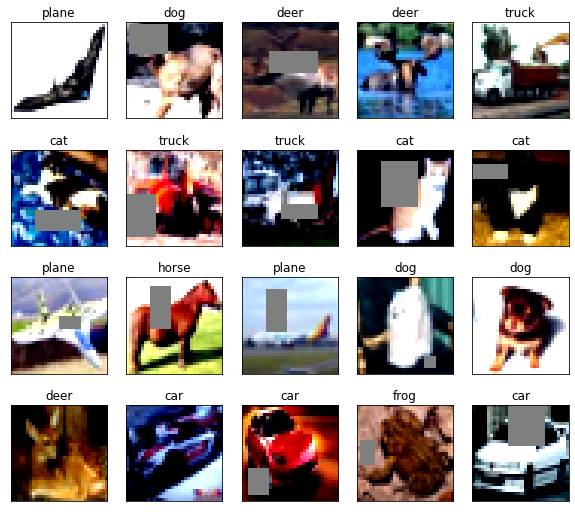

In [0]:
# visualize few training dataset images
putils.plot_dataset_images(device, classes, train_loader, save_filename="albumentations_images")

In [0]:
# Create CIFAR10 network using custome CNN network
#model = cifar10_net_cnn.Cifar10Net(drop_val=0.10)
#mutils.model_summary(model, device, input_size=(3, 32, 32))

# Create Resnet18 based CIFAR10 Network

In [0]:

# Create CIFAR10 network
model = resnet.ResNet18()
mutils.model_summary(model, device, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# Build and train model

In [0]:
model_name = "CIFAR10 Resnet18"
model =  model.to(device)
EPOCHS = config_params["epochs"]

#criterion = F.nll_loss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)  # using L2 Regulaization
lr_scheduler = MultiStepLR(optimizer, milestones=[8,16,24], gamma=0.3)

#not used
#lr_scheduler = OneCycleLR(optimizer,  max_lr=0.01,epochs=EPOCHS, steps_per_epoch=len(train_loader))
#lr_scheduler = MultiStepLR(optimizer, milestones=[4,8,12,16,20], gamma=0.3)
#lr_scheduler = StepLR(optimizer, step_size=8, gamma=0.1)
#lr_lambda = lambda epoch: 0.1/(1+1.2*(epoch-(epoch%3)))
#lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

model_history = mutils.build_model(model, 
                            device, 
                            trainloader=train_loader, 
                            testloader=test_loader, 
                            epochs=EPOCHS,
                            criterion=criterion, 
                            optimizer=optimizer,
                            lr_scheduler=lr_scheduler,
                            L1_loss_enable=True)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH-1: learning rate is: 0.01


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.229021, Accuracy: 5850/10000 (58.50%)

EPOCH-2: learning rate is: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.967227, Accuracy: 6864/10000 (68.64%)

EPOCH-3: learning rate is: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.644444, Accuracy: 7784/10000 (77.84%)

EPOCH-4: learning rate is: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.582530, Accuracy: 8008/10000 (80.08%)

EPOCH-5: learning rate is: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.577726, Accuracy: 8058/10000 (80.58%)

EPOCH-6: learning rate is: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.555651, Accuracy: 8134/10000 (81.34%)

EPOCH-7: learning rate is: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.599515, Accuracy: 7982/10000 (79.82%)

EPOCH-8: learning rate is: 0.01


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.547260, Accuracy: 8234/10000 (82.34%)

EPOCH-9: learning rate is: 0.003


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.380636, Accuracy: 8714/10000 (87.14%)

EPOCH-10: learning rate is: 0.003


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.375133, Accuracy: 8794/10000 (87.94%)

EPOCH-11: learning rate is: 0.003


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.391910, Accuracy: 8750/10000 (87.50%)

EPOCH-12: learning rate is: 0.003


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.396041, Accuracy: 8746/10000 (87.46%)

EPOCH-13: learning rate is: 0.003


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.392805, Accuracy: 8779/10000 (87.79%)

EPOCH-14: learning rate is: 0.003


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.417125, Accuracy: 8682/10000 (86.82%)

EPOCH-15: learning rate is: 0.003


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.452540, Accuracy: 8655/10000 (86.55%)

EPOCH-16: learning rate is: 0.003


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.431397, Accuracy: 8750/10000 (87.50%)

EPOCH-17: learning rate is: 0.0009


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.370331, Accuracy: 8858/10000 (88.58%)

EPOCH-18: learning rate is: 0.0009


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.365029, Accuracy: 8905/10000 (89.05%)

EPOCH-19: learning rate is: 0.0009


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.369164, Accuracy: 8872/10000 (88.72%)

EPOCH-20: learning rate is: 0.0009


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.370801, Accuracy: 8886/10000 (88.86%)

EPOCH-21: learning rate is: 0.0009


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.373879, Accuracy: 8909/10000 (89.09%)

EPOCH-22: learning rate is: 0.0009


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.387740, Accuracy: 8888/10000 (88.88%)

EPOCH-23: learning rate is: 0.0009


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.382143, Accuracy: 8850/10000 (88.50%)

EPOCH-24: learning rate is: 0.0009


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.380057, Accuracy: 8883/10000 (88.83%)

EPOCH-25: learning rate is: 0.00027


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.369093, Accuracy: 8908/10000 (89.08%)

EPOCH-26: learning rate is: 0.00027


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.367162, Accuracy: 8894/10000 (88.94%)

EPOCH-27: learning rate is: 0.00027


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.365416, Accuracy: 8909/10000 (89.09%)

EPOCH-28: learning rate is: 0.00027


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.379624, Accuracy: 8923/10000 (89.23%)

EPOCH-29: learning rate is: 0.00027


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.366947, Accuracy: 8926/10000 (89.26%)

EPOCH-30: learning rate is: 0.00027


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.369191, Accuracy: 8911/10000 (89.11%)

EPOCH-31: learning rate is: 0.00027


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.366896, Accuracy: 8927/10000 (89.27%)

EPOCH-32: learning rate is: 0.00027


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.363371, Accuracy: 8916/10000 (89.16%)

EPOCH-33: learning rate is: 0.00027


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.364872, Accuracy: 8919/10000 (89.19%)

EPOCH-34: learning rate is: 0.00027


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.362730, Accuracy: 8904/10000 (89.04%)

EPOCH-35: learning rate is: 0.00027


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.366941, Accuracy: 8911/10000 (89.11%)

EPOCH-36: learning rate is: 0.00027


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.366932, Accuracy: 8906/10000 (89.06%)

EPOCH-37: learning rate is: 0.00027


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.366998, Accuracy: 8904/10000 (89.04%)

EPOCH-38: learning rate is: 0.00027


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.383000, Accuracy: 8923/10000 (89.23%)

EPOCH-39: learning rate is: 0.00027


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.373352, Accuracy: 8924/10000 (89.24%)

EPOCH-40: learning rate is: 0.00027


Loss=0.275660 Batch_id=391 Accuracy=99.34: 100%|██████████| 391/391 [00:34<00:00, 12.99it/s]



Test set: Average loss: 0.376594, Accuracy: 8925/10000 (89.25%)



In [0]:
# Save the model for future use
filepath = "./saved_models/s9_resnet18"
torch.save(model, filepath)

# Analyse the train and test best result and calculate test accuracy for each classes

In [0]:
# model result summary
model_history.result_summary()

Training best result: Accuracy: 99.37 at Epoch 39
Testing  best result: Accuracy: 89.27 at Epoch 31
Acuracy Gap: 10.10


In [0]:
# get class based test accuracy for the network
mutils.class_based_accuracy(model, device, classes, test_loader)

Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 69 %
Accuracy of   cat : 83 %
Accuracy of  deer : 86 %
Accuracy of   dog : 78 %
Accuracy of  frog : 90 %
Accuracy of horse : 90 %
Accuracy of  ship : 96 %
Accuracy of truck : 100 %


# Visualize model history and network convergence

Visulaizing train and test result history

/content/gdrive/My Drive/TSAI/EVA_Phase1/session9/s9_submission/utils/model_history.py:110: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,x_size+1),x_size/10)
/content/gdrive/My Drive/TSAI/EVA_Phase1/session9/s9_submission/utils/model_history.py:121: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,x_size+1),x_size/10)


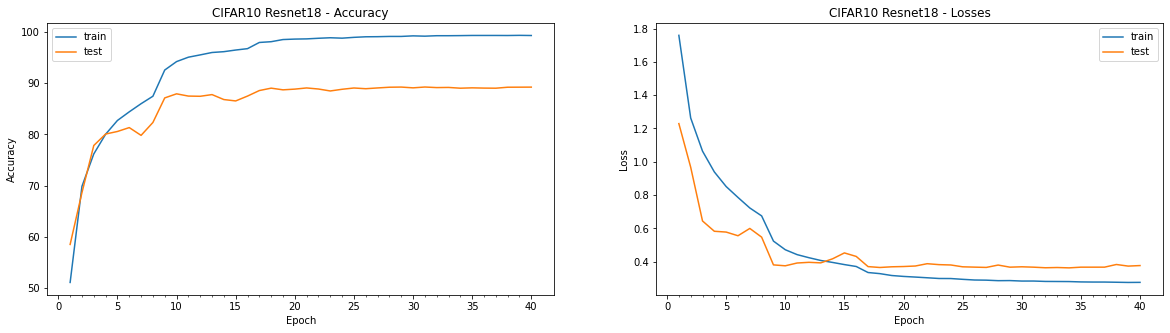

In [0]:
# Accurracy and loss history plot
model_history.plot_history(title=model_name, save_filename="model_history")

Learning rate plot

/content/gdrive/My Drive/TSAI/EVA_Phase1/session9/s9_submission/utils/model_history.py:68: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs.set_xticks(np.arange(1,x_size+1),x_size/10)


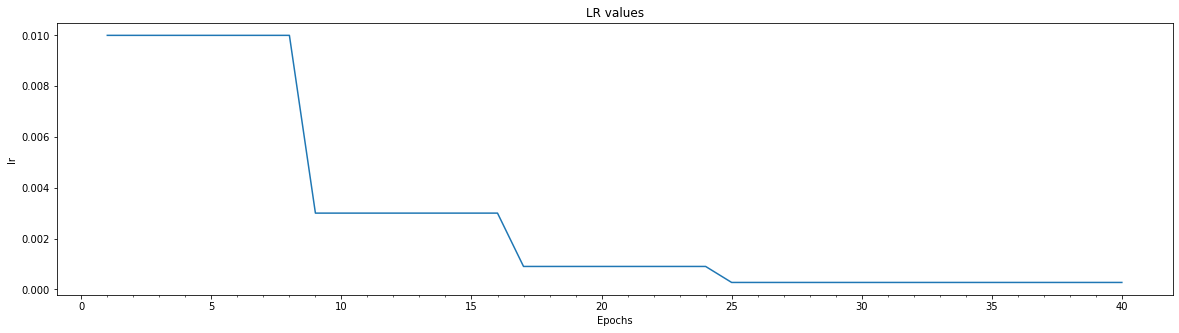

In [0]:
# Note: seriesname="val_acc", "val_loss", "train_acc", "train_loss", "lr"
model_history.plot_data_against_epoch("LR values", seriesname="lr", save_filename="lr_trend")

Test accuracy vs Leraning rate plot

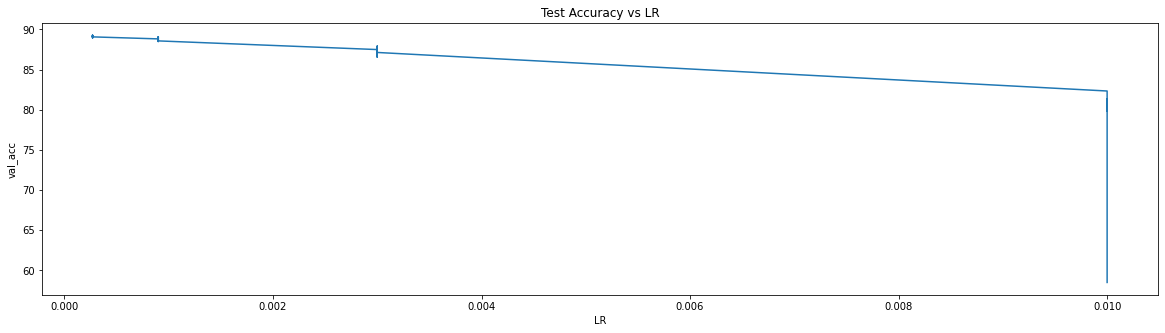

In [0]:
# NotE: seriesname="val_acc", "val_loss", "train_acc", "train_loss"
model_history.plot_data_against_lr("Test Accuracy vs LR", seriesname="val_acc", save_filename="test_acc_vs_lr")

Visualize few misclassified images and get an understanding on for what set of unseen data model is not performing good 


Ploting misclassified images: CIFAR10 Resnet18



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

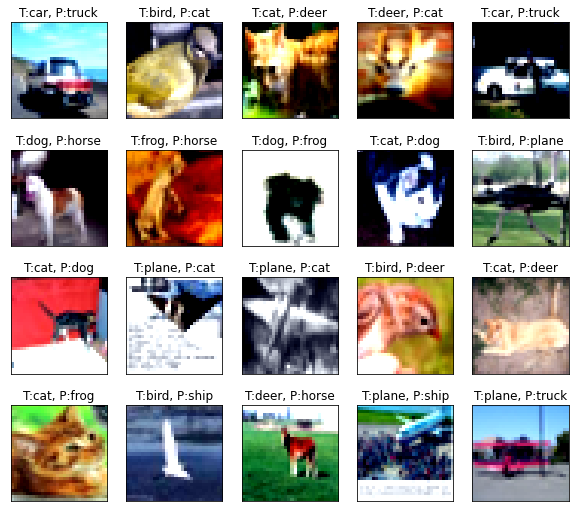

In [0]:
print("\nPloting misclassified images: {}\n".format(model_name))
putils.plot_misclassified_images(model, 
                          device, 
                          classes,
                          testloader=test_loader,
                          save_filename="model_misclassified")

# GradCAM

In [0]:
# reload the saved model
#filepath = "./saved_models/s9_resnet18"
#reloaded_model = torch.load(filepath)

In [0]:
# create instance of GradCam module
config = dict(model_type='resnet', arch=model, layer_name='layer4')
gcam = gradcamAbs.GradCamAbs(device, config, means, stds)

In [0]:
# apply GradCAM on few of the test images
gradcam_images, pred_results = gcam.applyOnImages(dataloader=test_loader, num_of_images=5)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


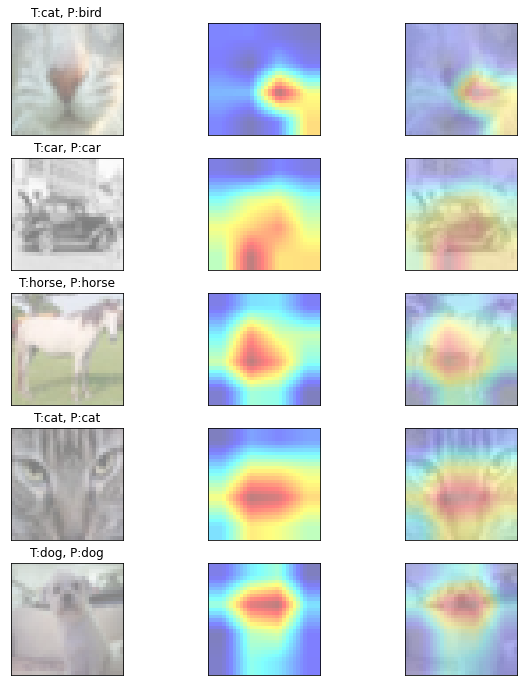

In [0]:
# plot the GradCAM result: original img, heatmap and super imposed image
gcam.plot_results(gradcam_images, pred_results, classes, save_filename="gradcam_result")